In [19]:
import pandas as pd

# save the patients_df
df = pd.read_csv('../data/msk_2024_mutations_final.csv')

# only select the columns we need first 263 columns and the last 2 columns
df = df.iloc[:, :263].join(df.iloc[:, -2:])
df

,Patient,PIK3CA,TP53,GATA3,ESR1,ALK,RNF43,TSHR,IRS1,NOTCH4,...,ERF,TAP2,AGO2,ELF3,SOS1,CSDE1,PRDM14,HLA-B,OS_MONTHS,OS_STATUS
0,P-0000015,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,13.906834,1:DECEASED
1,P-0000036,0,1,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,115.462887,0:LIVING
2,P-0000041,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,13.610944,1:DECEASED
3,P-0000066,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,76.635532,0:LIVING
4,P-0000058,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,60.756098,1:DECEASED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23539,P-0089676,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.032877,0:LIVING
23540,P-0089672,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5.589035,0:LIVING
23541,P-0000106,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.531504,1:DECEASED
23542,P-0009406,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,33.764347,1:DECEASED


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index

# Extract features (mutation presence) and target (survival months & status)
X = df.drop(columns=["Patient", "OS_MONTHS", "OS_STATUS"])
y_os = df["OS_MONTHS"].values  # Overall survival time
y_status = df["OS_STATUS"].apply(lambda x: 1 if "DECEASED" in x else 0).values  # Convert status to binary

# Train-Validation-Test Split
X_train, X_temp, y_os_train, y_os_temp, y_status_train, y_status_temp = train_test_split(
    X, y_os, y_status, test_size=0.3, random_state=42
)
X_val, X_test, y_os_val, y_os_test, y_status_val, y_status_test = train_test_split(
    X_temp, y_os_temp, y_status_temp, test_size=0.5, random_state=42
)

# Convert to PyTorch tensors
X_train, y_os_train, y_status_train = map(torch.tensor, (X_train.values, y_os_train, y_status_train))
X_val, y_os_val, y_status_val = map(torch.tensor, (X_val.values, y_os_val, y_status_val))
X_test, y_os_test, y_status_test = map(torch.tensor, (X_test.values, y_os_test, y_status_test))

# Move to float tensors
X_train, X_val, X_test = X_train.float(), X_val.float(), X_test.float()
y_os_train, y_os_val, y_os_test = y_os_train.float(), y_os_val.float(), y_os_test.float()
y_status_train, y_status_val, y_status_test = y_status_train.float(), y_status_val.float(), y_status_test.float()

print(f"Train Size: {X_train.shape}, Validation Size: {X_val.shape}, Test Size: {X_test.shape}")


Train Size: torch.Size([16480, 262]), Validation Size: torch.Size([3532, 262]), Test Size: torch.Size([3532, 262])


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# 0. MLP-Based Survival Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, hidden_dim_2)
        self.fc4 = nn.Linear(hidden_dim_2, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x.squeeze(-1)  # Ensure output is (batch,)

# 1. CNN-Based Survival Model
class CNNSurvival(nn.Module):
    def __init__(self, input_dim):
        super(CNNSurvival, self).__init__()
        # Treat the feature vector as a 1D "image" with one channel.
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, 1)
        
    def forward(self, x):
        # x: (batch, input_dim)
        x = x.unsqueeze(1)  # (batch, 1, input_dim)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.global_pool(x)  # (batch, 64, 1)
        x = x.view(x.size(0), -1)  # (batch, 64)
        risk = self.fc(x)          # (batch, 1)
        return risk.squeeze(-1)

# 2. LSTM-Based Survival Model
class LSTMSurvival(nn.Module):
    def __init__(self, input_dim, hidden_size=64, num_layers=1):
        super(LSTMSurvival, self).__init__()
        # Each feature is treated as a time step with dimension=1.
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # x: (batch, input_dim) -> reshape to (batch, seq_len, 1)
        x = x.unsqueeze(-1)  # (batch, input_dim, 1)
        output, (hn, cn) = self.lstm(x)
        risk = self.fc(hn[-1])
        return risk.squeeze(-1)

# 3. Transformer-Based Survival Model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 1:
            # For odd d_model, handle the extra dimension
            pe[:, 1::2] = torch.cos(position * div_term)[:, :pe[:, 1::2].shape[1]]
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # x: (batch, seq_len, d_model)
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len]
        return x

class TransformerSurvival(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2):
        super(TransformerSurvival, self).__init__()
        # Treat each feature as a time step with embedding dimension=1, then project to d_model.
        self.embedding = nn.Linear(1, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=input_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)
        
    def forward(self, x):
        # x: (batch, input_dim) -> reshape to (batch, seq_len, 1)
        x = x.unsqueeze(-1)  # (batch, input_dim, 1)
        x = self.embedding(x) # (batch, input_dim, d_model)
        x = self.pos_encoder(x)  # (batch, input_dim, d_model)
        x = x.transpose(0, 1)  # Transformer expects (seq_len, batch, d_model)
        x = self.transformer_encoder(x)  # (seq_len, batch, d_model)
        x = torch.mean(x, dim=0)  # Pool over sequence dimension -> (batch, d_model)
        risk = self.fc(x)         # (batch, 1)
        return risk.squeeze(-1)

In [22]:
# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train, y_os_train, y_status_train = X_train.to(device), y_os_train.to(device), y_status_train.to(device)
X_val, y_os_val, y_status_val = X_val.to(device), y_os_val.to(device), y_status_val.to(device)
X_test, y_os_test, y_status_test = X_test.to(device), y_os_test.to(device), y_status_test.to(device)

# normalize the y_os_train, y_os_val, y_os_test using log1p
y_os_train = torch.log1p(y_os_train)
y_os_val = torch.log1p(y_os_val)
y_os_test = torch.log1p(y_os_test)

In [23]:
def cox_partial_likelihood_loss(risk, time, event):
    """
    Compute the negative partial likelihood of the Cox proportional hazards model.
    
    Parameters:
      risk: Predicted risk score from the model, shape [N].
      time: Survival time (log-transformed), shape [N].
      event: Event indicator (1 if event occurred, 0 if censored), shape [N].
    """
    # Sort by descending survival time
    order = torch.argsort(time, descending=True)
    risk = risk[order]
    time = time[order]
    event = event[order]
    
    exp_risk = torch.exp(risk)
    # The cumulative sum gives the sum of exp(risk) for the risk set
    cum_sum = torch.cumsum(exp_risk, dim=0)
    
    # For each event, compute risk - log(sum_{j in risk set} exp(risk_j))
    diff = risk - torch.log(cum_sum)
    loss = -torch.sum(diff * event) / (torch.sum(event) + 1e-8)
    return loss
  
# Example Cox loss computed on a mini-batch
def cox_partial_likelihood_loss_batch(risk, time, event):
    """
    Compute the negative partial likelihood of the Cox model for a mini-batch.
    Note: The risk set is limited to the mini-batch, which is an approximation.
    """
    # Sort mini-batch by descending time
    order = torch.argsort(time, descending=True)
    risk = risk[order]
    time = time[order]
    event = event[order]
    
    exp_risk = torch.exp(risk)
    cum_sum = torch.cumsum(exp_risk, dim=0)
    
    diff = risk - torch.log(cum_sum + 1e-8)
    loss = -torch.sum(diff * event) / (torch.sum(event) + 1e-8)
    return loss

In [24]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset for Survival Data
class SurvivalDataset(Dataset):
    def __init__(self, X, time, event):
        self.X = X
        self.time = time
        self.event = event
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.time[idx], self.event[idx]

batch_size = 512  # Adjust based on your memory constraints

# Create dataset objects
train_dataset = SurvivalDataset(X_train, y_os_train, y_status_train)
val_dataset   = SurvivalDataset(X_val, y_os_val, y_status_val)
test_dataset  = SurvivalDataset(X_test, y_os_test, y_status_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# For validation and test we use full batches (since they are smaller)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)


In [25]:
# -------------------------
# Select Model Type: "MLP", "CNN", "LSTM", or "Transformer"
# -------------------------
model_type = "LSTM"  # Change to "MLP", "CNN", or "LSTM" as desired

# Assume X_train exists; if not, default to an example input dimension of 10.
input_dim = X_train.shape[1] if 'X_train' in globals() else 10

if model_type == "MLP":
    model = MLP(input_dim, hidden_dim_1=256, hidden_dim_2=128)
elif model_type == "CNN":
    model = CNNSurvival(input_dim)
elif model_type == "LSTM":
    model = LSTMSurvival(input_dim, hidden_size=64, num_layers=1)
elif model_type == "Transformer":
    model = TransformerSurvival(input_dim, d_model=64, nhead=4, num_layers=2)
else:
    raise ValueError("Invalid model type selected.")

print(model)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

LSTMSurvival(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [26]:
from lifelines.utils import concordance_index
from sklearn.metrics import roc_auc_score

num_epochs = 100
train_losses, val_losses, val_c_indices, val_aurocs = [], [], [], []

for epoch in range(num_epochs):
    # ---- Training Phase ----
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_time, batch_event in train_loader:
        batch_X, batch_time, batch_event = batch_X.to(device), batch_time.to(device), batch_event.to(device)
        optimizer.zero_grad()
        risk = model(batch_X)
        loss = cox_partial_likelihood_loss_batch(risk, batch_time, batch_event)
        loss.backward()
        optimizer.step()
            
        epoch_loss += loss.item() * batch_X.size(0)
    epoch_loss /= len(train_dataset)
    train_losses.append(epoch_loss)

    # ---- Validation Phase ----
    model.eval()
    with torch.no_grad():
        # We compute validation loss and predictions on the full validation set
        for val_X, val_time, val_event in val_loader:
            val_X, val_time, val_event = val_X.to(device), val_time.to(device), val_event.to(device)
            val_risk = model(val_X)
            val_loss = cox_partial_likelihood_loss_batch(val_risk, val_time, val_event)
            # Convert log-transformed times back to original scale for c-index
            val_risk_np = val_risk.cpu().numpy()
            val_time_np = val_time.cpu().numpy()
            val_event_np = val_event.cpu().numpy()
            val_time_orig = np.expm1(val_time_np)
            c_index = concordance_index(val_time_orig, -val_risk_np, val_event_np)
            try:
                auroc = roc_auc_score(val_event_np, val_risk_np)
            except Exception:
                auroc = np.nan
    
    val_losses.append(val_loss.item())
    val_c_indices.append(c_index)
    val_aurocs.append(auroc)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss {epoch_loss:.4f}, Val Loss {val_loss.item():.4f}, "
              f"c-index {c_index:.4f}, AUROC {auroc:.4f}")

Epoch 10/100: Train Loss 5.6427, Val Loss 7.5558, c-index 0.5110, AUROC 0.5313
Epoch 20/100: Train Loss 5.6418, Val Loss 7.5514, c-index 0.5112, AUROC 0.5298
Epoch 30/100: Train Loss 5.6447, Val Loss 7.5545, c-index 0.5091, AUROC 0.5279
Epoch 40/100: Train Loss 5.6414, Val Loss 7.5503, c-index 0.5029, AUROC 0.5209
Epoch 50/100: Train Loss 5.6406, Val Loss 7.5500, c-index 0.5034, AUROC 0.5213
Epoch 60/100: Train Loss 5.6390, Val Loss 7.5496, c-index 0.5029, AUROC 0.5208
Epoch 70/100: Train Loss 5.6409, Val Loss 7.5507, c-index 0.5060, AUROC 0.5242


KeyboardInterrupt: 

In [ ]:
model.eval()
with torch.no_grad():
    for test_X, test_time, test_event in test_loader:
        test_X, test_time, test_event = test_X.to(device), test_time.to(device), test_event.to(device)
        test_risk = model(test_X)
        test_loss = cox_partial_likelihood_loss_batch(test_risk, test_time, test_event)
        test_risk_np = test_risk.cpu().numpy()
        test_time_np = test_time.cpu().numpy()
        test_event_np = test_event.cpu().numpy()
        test_time_orig = np.expm1(test_time_np)
        test_c_index = concordance_index(test_time_orig, -test_risk_np, test_event_np)
        try:
            test_auroc = roc_auc_score(test_event_np, test_risk_np)
        except Exception:
            test_auroc = np.nan

print("\nFinal Test Metrics:")
print(f"Test Loss: {test_loss.item():.4f}")
print(f"Test c-index: {test_c_index:.4f}")
print(f"Test AUROC: {test_auroc:.4f}")


Final Test Metrics:
Test Loss: 12.5160
Test c-index: 0.5897
Test AUROC: 0.5980


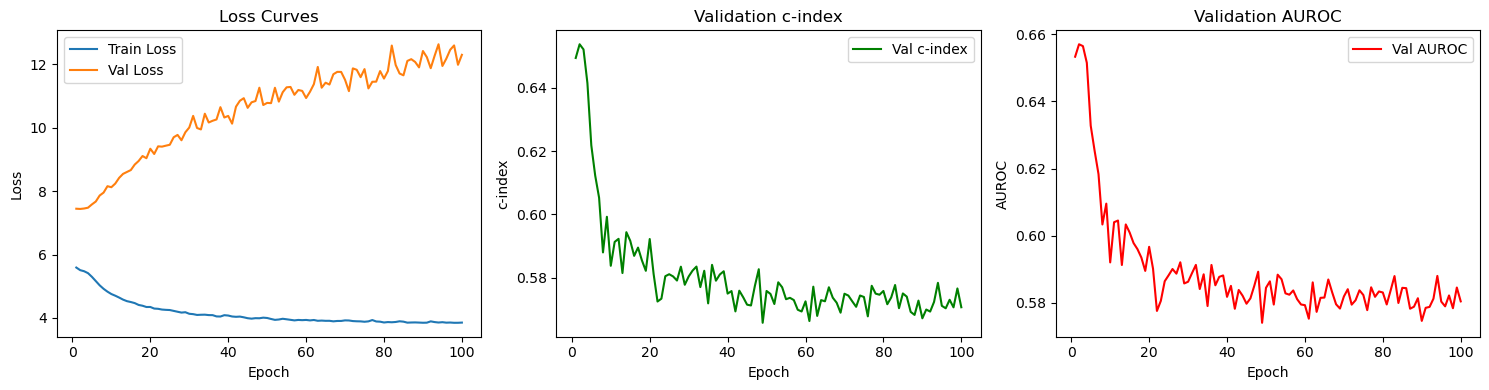

In [ ]:
epochs_arr = np.arange(1, num_epochs + 1)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs_arr, train_losses, label="Train Loss")
plt.plot(epochs_arr, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs_arr, val_c_indices, label="Val c-index", color='green')
plt.xlabel("Epoch")
plt.ylabel("c-index")
plt.title("Validation c-index")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs_arr, val_aurocs, label="Val AUROC", color='red')
plt.xlabel("Epoch")
plt.ylabel("AUROC")
plt.title("Validation AUROC")
plt.legend()

plt.tight_layout()
# save the plot
plt.savefig('../figures/survival_model.png')

plt.show()